In [1]:
# Imports
import torch
import torchvision 
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from PIL import Image
import spectral as spec

from dataGen import Patches
from ResNet_75.ResNet_75 import ResNet_75 as CNN

E:\Software\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def tensorToImg(tensor):
    img = torch.zeros(img_size, img_size, 1)
    for c_y, y in enumerate(tensor[0]):
        for c_x, x in enumerate(y):
            img[c_y][c_x] = x
    return img

In [3]:
def displayImgs(imgs, labels, save=False):
    fig = plt.figure(figsize=(20,11))
    for pos, i in enumerate(imgs[:8]):
        img = tensorToImg(i)
        label = "downy mildew"
        if labels[pos] == 0:
            label = "Non-disease"
        fig.add_subplot(4, 8, pos + 1).title.set_text(label)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

In [4]:
def predictPatch(loader, model, savefig=False):
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            displayImgs(x, predictions, savefig)
            break
    model.train()

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Hyperparameters
in_channels = 75
num_classes = 2
img_size = 12
batch_size = 128

model_dir = os.getcwd() + "\\ResNet_75\\ResNet_75_14_21_25_28_노균병_t70.pt"

In [7]:
# Transformers
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])
img_transform

Compose(
    ToTensor()
    Resize(size=(12, 12), interpolation=bilinear)
    ConvertImageDtype()
)

In [8]:
# Custom Image Dataset
class Img(Dataset):
    def __init__(self, img_df, transform=None, s=100):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, :])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [9]:
patch_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES")
patch_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES")
patch_25 = Patches("D:\\gyeongsang_22_10_25\\PATCHES")
patch_28 = Patches("E:\\gyeongsang_22_10_28\\PATCHES")

In [10]:
print(patch_14.describe(),
      patch_21.describe(),
      patch_25.describe(),
      patch_28.describe())

For hdr image, there are: 
 leaf          5254
background    2737
diseased        83
Name: class, dtype: int64
For jpg image, there are: 
 leaf          5254
background    2737
diseased        83
Name: class, dtype: int64
For hdr image, there are: 
 leaf          5933
background    4746
diseased        76
Name: class, dtype: int64
For jpg image, there are: 
 leaf          5933
background    4746
diseased        76
Name: class, dtype: int64
For hdr image, there are: 
 leaf          3554
background    3247
diseased       135
Name: class, dtype: int64
For jpg image, there are: 
 leaf          3554
background    3247
diseased       135
Name: class, dtype: int64
For hdr image, there are: 
 background    12995
leaf           8122
diseased        245
Name: class, dtype: int64
For jpg image, there are: 
 background    12995
leaf           8122
diseased        245
Name: class, dtype: int64
None None None None


In [11]:
def getDataset(patch, dc):
    p = patch.generateDataset(
        dataset_composition = [
            ['diseased',    dc[0]],
            ['leaf',        dc[1]],
            ['background',  dc[2]]],
        data_type = 'hdr')
    
    p.loc[(p['class'] == 'background'), 'class'] = 0
    p.loc[(p['class'] == 'leaf'), 'class'] = 0
    p.loc[(p['class'] == 'diseased'), 'class'] = 1

    print(p.describe())
    
    return p

In [12]:
patch_14_ds = getDataset(patch_14, [83, 415, 415])
patch_21_ds = getDataset(patch_21, [76, 380, 380])
patch_25_ds = getDataset(patch_25, [135, 675, 675])
patch_28_ds = getDataset(patch_28, [245, 1225, 1225])
patch_dataset = pd.concat([patch_14_ds, patch_21_ds, patch_25_ds, patch_28_ds])

                                                     path type  class
count                                                 913  913    913
unique                                                913    1      2
top     D:\gyeongsang_22_10_14\PATCHES\MOS_CAL_GEOREF_...  hdr      0
freq                                                    1  913    830
                                                     path type  class
count                                                 836  836    836
unique                                                836    1      2
top     D:\gyeongsang_22_10_21_1\PATCHES\MOS_CAL_GEORE...  hdr      0
freq                                                    1  836    760
                                                     path  type  class
count                                                1485  1485   1485
unique                                               1485     1      2
top     D:\gyeongsang_22_10_25\PATCHES\MOS_CAL_GEOREF_...   hdr      0
freq            

In [13]:
dataset_14 = DataLoader(dataset=Img(img_df=patch_14_ds, transform=img_transform), batch_size=batch_size, shuffle=True)
dataset_21 = DataLoader(dataset=Img(img_df=patch_21_ds, transform=img_transform), batch_size=batch_size, shuffle=True)
dataset_25 = DataLoader(dataset=Img(img_df=patch_25_ds, transform=img_transform), batch_size=batch_size, shuffle=True)
dataset_28 = DataLoader(dataset=Img(img_df=patch_28_ds, transform=img_transform), batch_size=batch_size, shuffle=True)

dataset = DataLoader(dataset=Img(img_df=patch_dataset, transform=img_transform), batch_size=batch_size, shuffle=True)

In [14]:
next(iter(dataset))[0].shape   

torch.Size([128, 75, 12, 12])

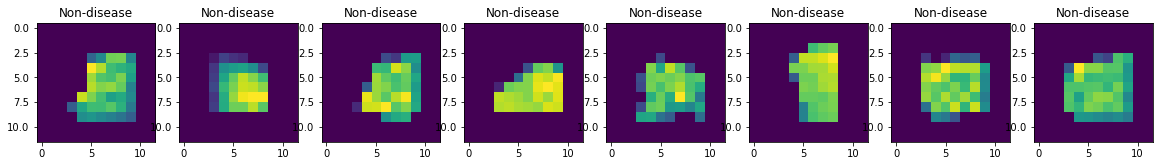

In [15]:
for train_sample in dataset:
    displayImgs(train_sample[0], train_sample[1], save=False)
    break

In [16]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

In [17]:
# Load weights
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [18]:
model.eval()

ResNet_75(
  (conv1): Conv2d(75, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (downsample): Sequential(
    (0): Conv2d(75, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=512, bias=

In [19]:
# Predict 
def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    model.train()
    
    return actual, prediction

In [22]:
actual_14, prediction_14 = predictDataset(dataset_14, model)
actual_21, prediction_21 = predictDataset(dataset_21, model)
actual_25, prediction_25 = predictDataset(dataset_25, model)
actual_28, prediction_28 = predictDataset(dataset_28, model)

actual, prediction = predictDataset(dataset, model)

In [43]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=True):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["non-diseased", "diseased"])
    cm_display.plot()
    
    if savefig:
        cm_display.figure_.savefig('conf_mat.png')

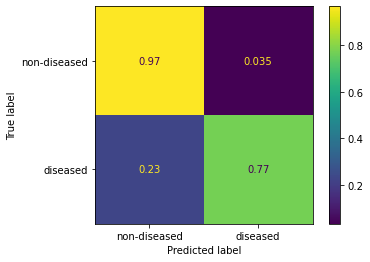

In [44]:
drawConfusionMatrix(actual_14, prediction_14, normalize=True)

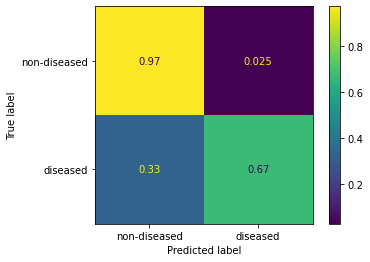

In [46]:
drawConfusionMatrix(actual_21, prediction_21, normalize=True)

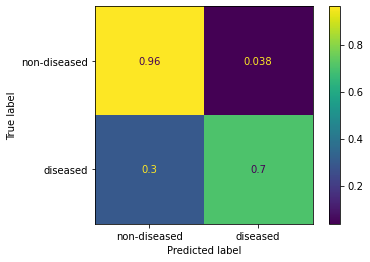

In [47]:
drawConfusionMatrix(actual_25, prediction_25, normalize=True)

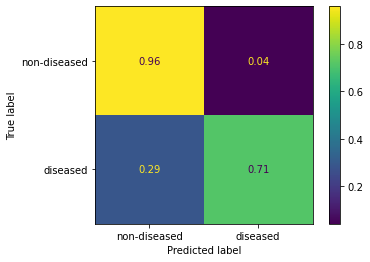

In [48]:
drawConfusionMatrix(actual_28, prediction_28, normalize=True)

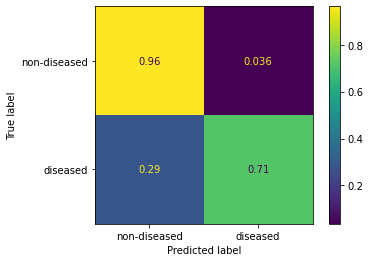

In [28]:
drawConfusionMatrix(actual, prediction, normalize=True)